In [2]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
from CL_utilities.top5_efficiency import top5eff
import numpy as np
import keras
from CL_utilities import loss_function
import tensorflow as tf
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import Callback
from utilities.test_products_generator import TestProductsGenerator
from metrics.Metrics import Metrics
from keras.optimizers import SGD

# Hyperparameters

In [3]:
image_size = (224, 224)
epochs = 10
batch_size = 16
margin = 0.5
training_pairs = 280
validation_pairs = 100
training_path = r"./data/FruitRecognition/Training"
validation_path = r"./data/FruitRecognition/Validation"

# Building training dataset 
# (1.) See Documentation to get info about structure of dataset

In [5]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(224, 224, 3)


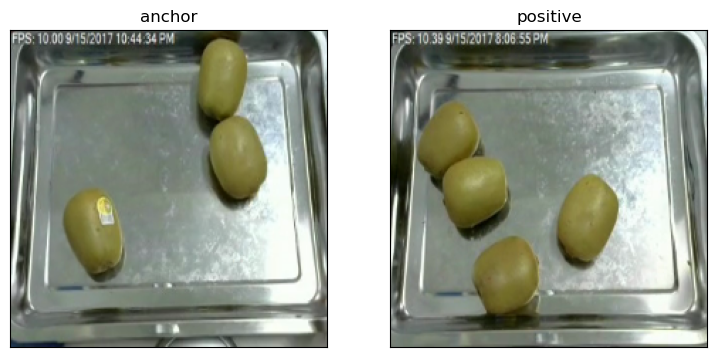

In [6]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

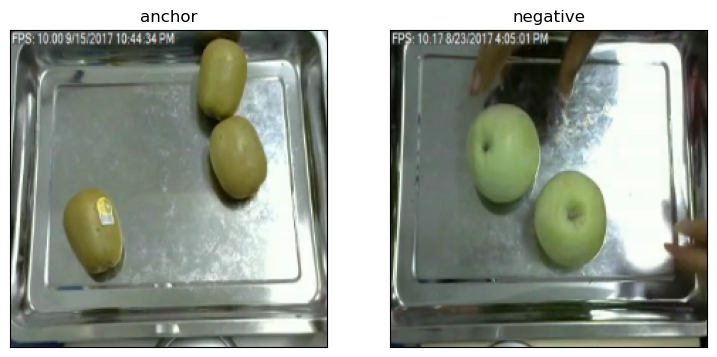

In [7]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

# Creating validation dataset

In [8]:
validation_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(validation_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(224, 224, 3)


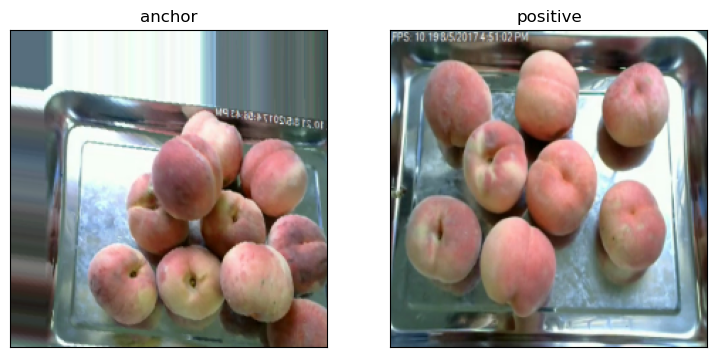

In [9]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

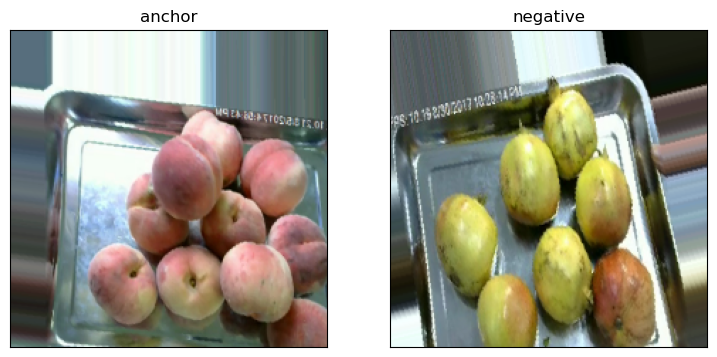

In [10]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

In [11]:
# LOAD MODEL (TRANSFER LEARNING)

from tensorflow.keras.applications import VGG16
modelVGG = VGG16(weights='imagenet', include_top=False)

In [12]:
input_layer = keras.layers.Input((224,224,3))
x = modelVGG(input_layer)
# x = keras.layers.BatchNormalization()(input_layer)
# x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
# x = keras.layers.Conv2D(128, (3,3), activation="relu")(x)
# x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
x = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
embedding_network = keras.Model(input_layer, x)   # create instance of model called embedding_network


In [13]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)
 
merge_layer_distance = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])
siamese = keras.Model(inputs=[input_1, input_2], outputs=merge_layer_distance)

## Load trained wages

In [14]:
#Load wages (need to have same structure of model) 
#Uncomment if need:

#siamese.load_weights('trained_models/VGG16_32_16_testing1.h5')


#!! When loading model, the each layer.trainable must be at same comfiguration as in previous
# model. And after load_weights  : we can change trainable of layers to new configuration.

### Set what to train in transfered model:

In [15]:
#Transfer MODEL: 
for layer in modelVGG.layers:
    layer.trainable = False
    
    
# FineTune the last few convolutional layers
#--------------------------------------
# for layers in modelVGG.layers[:-3]:
#     layers.trainable = False
# for layers in modelVGG.layers[-3:]:
#     layers.trainable = True
#--------------------------------------


### Set learining rate and Early Stop :

In [16]:
# SET CALLBACKS
# The number of parameter "patience" has to be configured to number of epochs
# good if : n_epochs >= patience * 2
EarlyStop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience='5')

# Value of patience have to be smaller than in EarlyStopping because 
# at first try change of learning rate in next epochs
# then we can stop training if also not improve 
reduce_lr = keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor = 0.2,
                                               patience = '3', verbose=1, min_lr= 0.001,
                                               mode = 'min')


# Set optimizer

In [17]:
# Model compile for standard learning:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam')

# Model compile for fine-tune the last few layers of convolutional from loaded model
#-------------------------------------------------------
# sgd = SGD(learning_rate=0.1, momentum = 0.9)
# siamese.compile(loss=loss_function.loss(margin=margin), optimizer=sgd)
#-------------------------------------------------------

In [18]:
########################################################################################################################################

In [19]:
# CREATE MEAN (of 5 IMAGES) REPRESENTATIVE VECTOR FOR EACH CLASS
import tensorflow as tf
from utilities.mapping import Mapper
import os
import random
import shutil

@staticmethod
class Representatives:
    def __init__(self, image_size):
        self.list_of_images = []
        self.list_of_labels = []
        self.List_mean_feature_vector_shop = np.zeros((23,16))
        self.image_size = image_size
        
    #RANDOM_REPRESENTATIVES
    def create_representatives(self, number_of_representative):
        self.number_of_representative = number_of_representative

        shop_path = os.path.abspath("data/Fruits360/Shop360_database")
        validation_path = r"./data/Fruits360/Validation/"

        for type_of_product in os.listdir(validation_path):
            val_dir = os.path.join(validation_path, type_of_product)
            shop_class_dir = os.path.join(shop_path, type_of_product)

            os.makedirs(shop_class_dir, exist_ok=True)

            for filename in os.listdir(shop_class_dir):
                file_path = os.path.join(shop_class_dir, filename)
                os.remove(file_path)

            files = [f for f in os.listdir(val_dir)]    #list of images

            for i in range(self.number_of_representative):
                random_selected_representative = random.choice(files)
                path_representative = os.path.join(val_dir,random_selected_representative)
                destination_path = os.path.join(shop_class_dir, random_selected_representative)
                shutil.copy(path_representative, destination_path)          
    def get_mean_representatives_for_each_class(self, fruit_names, fruit_paths, number_of_representative):
        self.fruits_names = fruit_names
        self.fruits_paths = fruit_paths
        self.number_repr = number_of_representative
        i=0
        j=0

        for i in range(len(fruits_paths)):
            for j in range(self.number_repr):
                path_to_image = Mapper(image_size)
                image = path_to_image._decode_and_resize(fruits_paths[i][j])
                self.list_of_images.append(image)
                self.list_of_labels.append(fruits_names[i])
            #print(list_of_labels)
        
            #___________________Get dimensions__________________________
            num_of_images = self.number_repr#len(list_of_images[0])  #one mean for each class
            size_feature_vector = embedding_network(tf.expand_dims(self.list_of_images[0], axis=0)).numpy()
            size_feature_vector = size_feature_vector.shape[1]   #get length
            #___________________________________________________________
            
            list_class_vectors = np.zeros((num_of_images, size_feature_vector))
                
            # Get 10 different images from test 
            for num in range(self.number_repr):
                list_class_vectors[num] = embedding_network(tf.expand_dims(self.list_of_images[num], axis=0)).numpy()   
                
            mean_feature_vector = np.mean(list_class_vectors, axis=0)   # mean vector for all representatives of class
            self.List_mean_feature_vector_shop[i] = mean_feature_vector
            #print(fruits_names[i])
            #print(self.List_mean_feature_vector_shop[i])
        
            self.list_of_images.clear()
            self.list_of_labels.clear()
            
        return self.List_mean_feature_vector_shop

In [20]:
def distance_between_vectors(vector1, vector2):
    vector1 = vector1 / tf.norm(vector1)   # length ov vector == 1
    vector2 = vector2 / tf.norm(vector2)
    sum_square = np.sum(np.square(vector1 - vector2))
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

In [22]:
import random
def create_test_images():
    camera_images_list = []
    camera_labels_list = []
    path_test_eff = 'data/FruitRecognition/Test'
    data = DatasetFactory.give_paths_to_test(path_test_eff, 1)
    
    
    # Get random 10 images from each class
    camera_paths = [random.sample(paths_list, 10) for paths_list in data.values() if len(paths_list) >= 10]
    camera_paths = [path for sublist in camera_paths for path in sublist]  # Spłaszczanie listy list
    camera_names = [path.split('/')[-2] for path in camera_paths]  # Zakładam, że nazwa folderu jest właściwym labelem
    
    
    camera_feature_vector = np.zeros((len(camera_paths), 16))
    #print(len(camera_paths))
    # Preparing images
    for i in range(len(camera_paths)):
        path_to_image1 = Mapper(image_size)
        img  = path_to_image1._decode_and_resize(camera_paths[i])
        camera_images_list.append(img)
        camera_labels_list.append(camera_names[i])  
        camera_feature_vector[i] = embedding_network(tf.expand_dims(camera_images_list[i],axis=0)).numpy()
        
    # Calculate distances between feature vectors 
    distances = np.zeros(23)  # There are 23 classes
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector, List_mean_feature_vector_shop[i])
        
    return camera_feature_vector, distances, camera_paths, camera_names

In [23]:
# To create RANDOM representatives
# num_of_imag_per_class = 10
# Representatives(image_size).create_representatives(num_of_imag_per_class)
        
camera_path = 'data/FruitRecognition/representatives/represent_5'
paths = DatasetFactory.give_paths_to_test(camera_path, 10)
fruits_names = []
fruits_paths = []
fruits_names = [key.split('/')[-1] for key in paths.keys()]
fruits_paths = [value for value in paths.values()]  # Get 5 representatives for each class



In [24]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        # On each epoch create new embeddings for representatives and test
        # Each epoch have better performance of model so need to create new embeddings
        num_img = 5
        object_of_representant = Representatives(image_size)
        global List_mean_feature_vector_shop
        List_mean_feature_vector_shop = object_of_representant.get_mean_representatives_for_each_class(fruits_names, fruits_paths, num_img)
        print(List_mean_feature_vector_shop)
        camera_feature_vector, distances, camera_paths, camera_names = create_test_images()
        
        # Calculate metric TOP5 Efficiency
        efficiency = 0.
        eff_one_example = 0.
        for num_camera_images in range(len(camera_paths)):  #230 (10 images for each class)
            for i in range(23):
                distances[i] = distance_between_vectors(camera_feature_vector[num_camera_images], List_mean_feature_vector_shop[i])
            top5_dist, top5_lab = top5eff().find_top_5(distances, fruits_names)
            eff_one_example = top5eff().give_efficiency(camera_names[num_camera_images], top5_lab, top5_dist)
            efficiency += eff_one_example
            
            # Print wrong classified images 
            #if(eff_one_example <= 0.92):
                #print(top5_lab)
                #print(camera_names[num_camera_images])
                #print(camera_paths[num_camera_images])
            
        efficiency = efficiency/len(camera_paths)*100
        print(f"Efficiency of model in our metric: {efficiency}")
        logs['top5_metric'] = efficiency

In [25]:
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 16)        │ 16,321,680 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,321,680 (62.26 MB)

 Trainable params: 1,606,864 (6.13 MB)

 Non-trainable params: 14,714,816 (56.13 MB)

In [26]:
########################################################################################################################################

# PARAMETERS of model

+ run:  siamese.fit if want to train new parameters
  + run: siamese.save_wages() if want to save trained parameters

+ run: siamese.load_wages() if want to load saved parameters (need to have same structure of model)

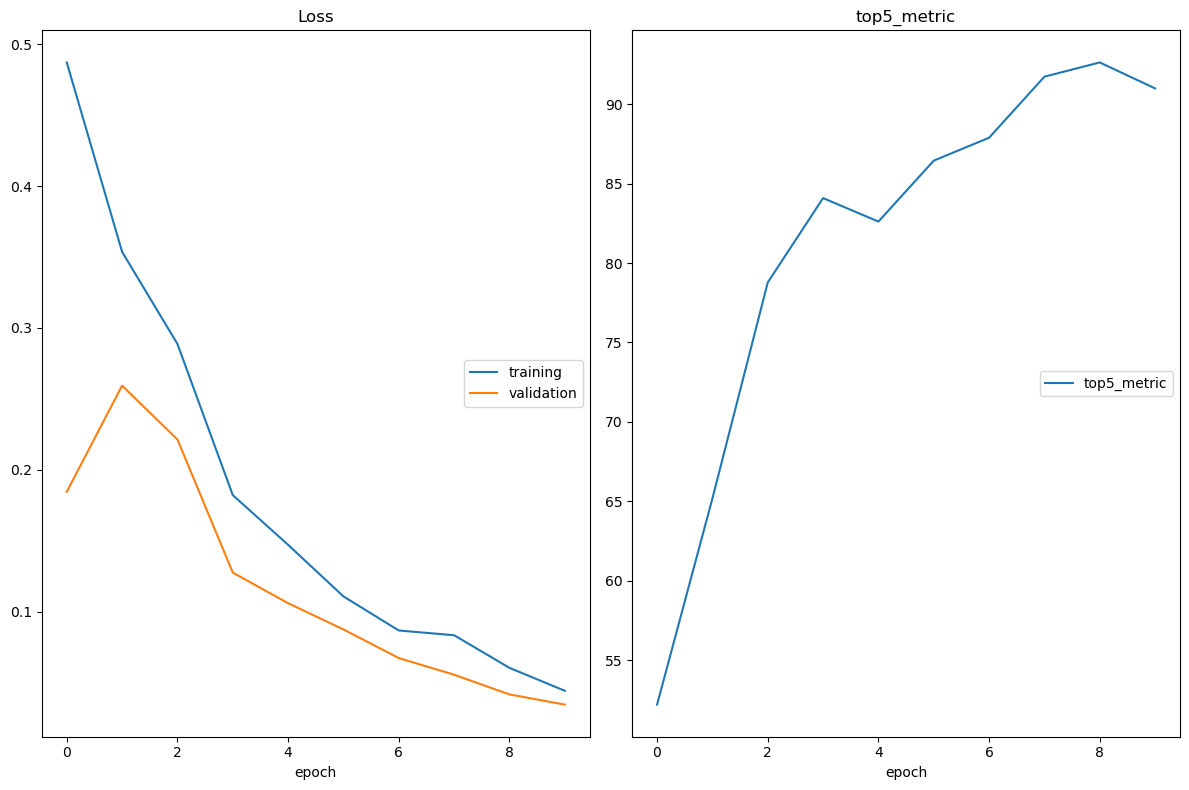

Loss
	training         	 (min:    0.044, max:    0.487, cur:    0.044)
	validation       	 (min:    0.034, max:    0.259, cur:    0.034)
top5_metric
	top5_metric      	 (min:   52.200, max:   92.626, cur:   90.991)
35/35 ━━━━━━━━━━━━━━━━━━━━ 188s 5s/step - loss: 0.0448 - val_loss: 0.0345 - top5_metric: 90.9913


In [27]:
Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 callbacks = [CustomCallback(), PlotLossesKeras()]
                                )

# wages:

In [25]:
#Saving wages (Only after trained model)
siamese.save_weights('trained_models/VGG16_32_16_testing1.h5')


# Distances

In [28]:
np.set_printoptions(precision=4)

distance1 = distance_between_vectors(List_mean_feature_vector_shop[0], List_mean_feature_vector_shop[16])
distance2 = distance_between_vectors(List_mean_feature_vector_shop[7], List_mean_feature_vector_shop[20])

print(f"Distance between {fruits_names[0]} and {fruits_names[16]}  == {distance1}")
print(f"Distance between {fruits_names[7]} and {fruits_names[20]}  == {distance2}\n")



Distance between muskmelon and Tomatoes  == 0.5334553935701095
Distance between guava B and Plum  == 0.787352641797086



### Eventually upgrade if possible

In [29]:
# test_path = 'data/FruitRecognition/Test'
# test_generator = TestProductsGenerator(test_path)

In [30]:
# efficiency = 0.
# test_length = 0.
# mapper = Mapper(image_size)
# 
# for _ in range(10):
#     l, p = next(iter(test_generator.get_next_element()))
#     label, image = mapper.map_single_product(l,p)
#     label = label.rsplit('/', 1)[1]
#     image_path = p
#     image = tf.reshape(image, shape=(1,) + image_size + (3,))
#     embedding = np.asarray(embedding_network(image)).astype('float32')
#     distances = np.zeros(len(List_mean_feature_vector_shop)) #23
#     labels = []
#     efficiency_sum = 0
#     for i in range(len(List_mean_feature_vector_shop)):
#         distances[i] = EuclideanDistance.calculate_distance((embedding, List_mean_feature_vector_shop[i]))
#         labels.append(object_of_representant.fruits_names[i])
#     top5_dist, top5_labels = Metrics.find_top_5(distances, labels)
#     efficiency_sum += Metrics.calculate_efficiency(label, top5_labels)
#     print(label)
#     print(top5_labels)
#     test_length += 1
#     
# overall_efficiency = efficiency_sum / test_length
# print(overall_efficiency)
#     
#     
    